In [1]:
#Imports and Installs, uncomment the install for first run
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# LOADING DATA

In [2]:
#Data stored in Google Drive, must authenticate to pull data
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
#01_M02_DC_train
#https://drive.google.com/file/d/1DO8bKxsTZe8gQ_zNnf6X1-9xlsWw37y2/view?usp=sharing
fileDownloaded = drive.CreateFile({'id':'1DO8bKxsTZe8gQ_zNnf6X1-9xlsWw37y2'})
fileDownloaded.GetContentFile('01_M02_DC_train.csv')

#01_M02_train_fault_data
#https://drive.google.com/file/d/1dppx60e2tdu4nm2XvZ1lRlMVPnVI4cvV/view?usp=sharing
fileDownloaded = drive.CreateFile({'id':'1dppx60e2tdu4nm2XvZ1lRlMVPnVI4cvV'})
fileDownloaded.GetContentFile('01_M02_train_fault_data.csv')

#01_M02_DC_train_ttf
#https://drive.google.com/file/d/1xBhlyjDhO1t_jXJLsKxP-SXD0XhKtmAU/view?usp=sharing
fileDownloaded = drive.CreateFile({'id':'1xBhlyjDhO1t_jXJLsKxP-SXD0XhKtmAU'})
fileDownloaded.GetContentFile('01_M02_DC_train_ttf.csv')

#loading into CSVs
df_train = pd.read_csv('01_M02_DC_train.csv', delimiter=',')
df_train.set_index('time')
df_train.head()

df_fault = pd.read_csv('01_M02_train_fault_data.csv', delimiter=',')
df_fault.set_index('time')
df_fault.head()

df_ttf = pd.read_csv('01_M02_DC_train_ttf.csv', delimiter=',')
df_ttf.set_index('time')
df_ttf.head()

#Make sure the TTFs are all divisible by 4, and subtract mod 4 if not
df_ttf['TTF_FlowCool Pressure Dropped Below Limit'] = df_ttf['TTF_FlowCool Pressure Dropped Below Limit'].sub(df_ttf['TTF_FlowCool Pressure Dropped Below Limit'] % 4)
df_ttf['TTF_Flowcool Pressure Too High Check Flowcool Pump'] = df_ttf['TTF_Flowcool Pressure Too High Check Flowcool Pump'].sub(df_ttf['TTF_Flowcool Pressure Too High Check Flowcool Pump'] % 4)
df_ttf['TTF_Flowcool leak'] = df_ttf['TTF_Flowcool leak'].sub(df_ttf['TTF_Flowcool leak'] % 4)

#set failure time to mod 4 as well so the time index matches other datasets
df_fault['time'] = df_fault['time'].sub(df_fault['time'] % 4)

#sanity check
print(df_ttf.loc[df_ttf['TTF_FlowCool Pressure Dropped Below Limit'].isin([1, 2, 3])])
print(df_ttf.loc[df_ttf['TTF_Flowcool Pressure Too High Check Flowcool Pump'].isin([1, 2, 3])])
print(df_ttf.loc[df_ttf['TTF_Flowcool leak'].isin([1, 2, 3])])

Empty DataFrame
Columns: [time, TTF_FlowCool Pressure Dropped Below Limit, TTF_Flowcool Pressure Too High Check Flowcool Pump, TTF_Flowcool leak]
Index: []
Empty DataFrame
Columns: [time, TTF_FlowCool Pressure Dropped Below Limit, TTF_Flowcool Pressure Too High Check Flowcool Pump, TTF_Flowcool leak]
Index: []
Empty DataFrame
Columns: [time, TTF_FlowCool Pressure Dropped Below Limit, TTF_Flowcool Pressure Too High Check Flowcool Pump, TTF_Flowcool leak]
Index: []


In [ ]:
#MISSING DATA ANALYSIS
# df_test = pd.DataFrame(columns=['Col1'])
# df_test['Col1'] = df_train['time'].diff()
# df_test.loc[df_test['Col1'] != 4]

# df_test.sort_values(by='Col1', ascending=False)

# print(39789840 - 3283834)
# print(36506006 - 5110542)

# for i in df_fault.index:
#     if df_fault['fault_name'][i] == 'Flowcool Pressure Too High Check Flowcool Pump':
#       print(df_fault['time'][i])

# for i in df_fault.index:
#     if df_fault['fault_name'][i] == 'Flowcool Pressure Too High Check Flowcool Pump':
#       display(df_f2.loc[df_f2['time'] == df_fault['time'][i]])

In [25]:
#join the ttf and training data together on time
df = pd.concat([df_train, df_ttf], axis=1, join = 'inner')
df.columns = ['time', 'Tool', 'stage', 'Lot', 'runnum', 'recipe', 'recipe_step','IONGAUGEPRESSURE', 'ETCHBEAMVOLTAGE', 'ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE', 'ETCHSUPPRESSORCURRENT', 'FLOWCOOLFLOWRATE','FLOWCOOLPRESSURE', 'ETCHGASCHANNEL1READBACK', 'ETCHPBNGASREADBACK','FIXTURETILTANGLE', 'ROTATIONSPEED', 'ACTUALROTATIONANGLE','FIXTURESHUTTERPOSITION', 'ETCHSOURCEUSAGE', 'ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER', 'ACTUALSTEPDURATION', 'time_drop','TTF_FlowCool Pressure Dropped Below Limit','TTF_Flowcool Pressure Too High Check Flowcool Pump','TTF_Flowcool leak']
#drop excess "time" column by position
df = df.drop(df.columns[24],axis = 1)

#FSP of 1 is the only important data
df = df.loc[df['FIXTURESHUTTERPOSITION'] == 1]
#drop NaNs that are present at the end of ttf (no more failures)
df = df.dropna(subset=['TTF_FlowCool Pressure Dropped Below Limit','TTF_Flowcool Pressure Too High Check Flowcool Pump', 'TTF_Flowcool leak'], how='all')
#drop duplicates ignoring the time and TTF columns
df.drop_duplicates(subset=df.columns.difference(['time', 'TTF_FlowCool Pressure Dropped Below Limit', 'TTF_Flowcool Pressure Too High Check Flowcool Pump',	'TTF_Flowcool leak']))

#Make 3 dataframes, one for each fail type
df_f1 = df.drop(['TTF_Flowcool Pressure Too High Check Flowcool Pump', 'TTF_Flowcool leak'],axis = 1)
df_f1 = df_f1.dropna()
df_f2 = df.drop(['TTF_FlowCool Pressure Dropped Below Limit',          'TTF_Flowcool leak'],axis = 1)
df_f2 = df_f2.dropna()
df_f3 = df.drop(['TTF_FlowCool Pressure Dropped Below Limit', 'TTF_Flowcool Pressure Too High Check Flowcool Pump'],axis = 1)
df_f3 = df_f3.dropna()

#only keep the data within 6000 seconds of a failure  to closer analyze the data
df_f1 = df_f1.loc[df['TTF_FlowCool Pressure Dropped Below Limit'] < 6000]
df_f2 = df_f2.loc[df['TTF_Flowcool Pressure Too High Check Flowcool Pump'] < 6000]
df_f3 = df_f3.loc[df['TTF_Flowcool leak'] < 6000]

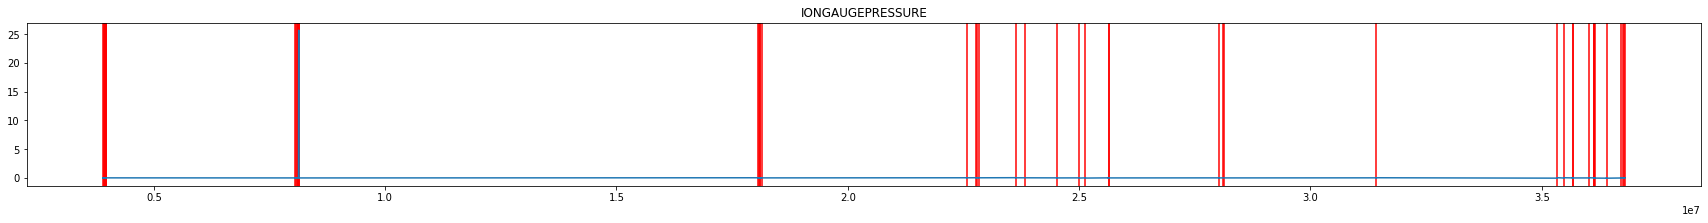

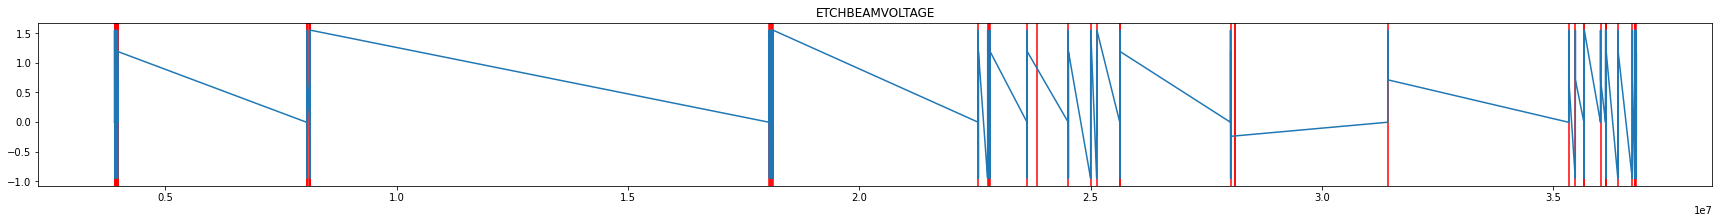

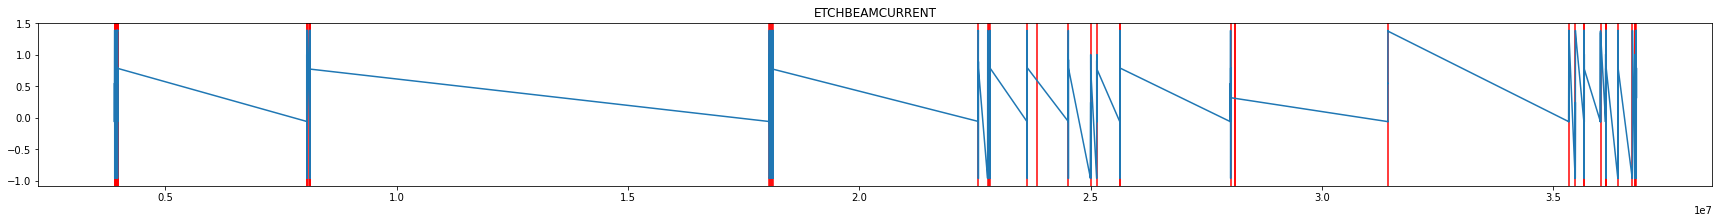

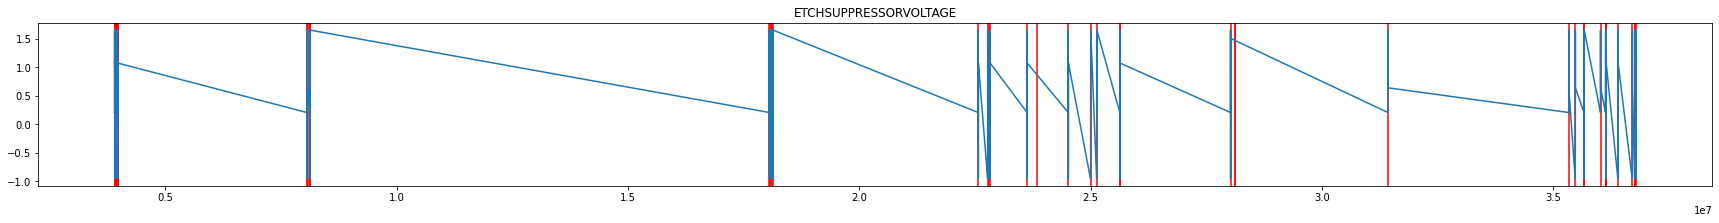

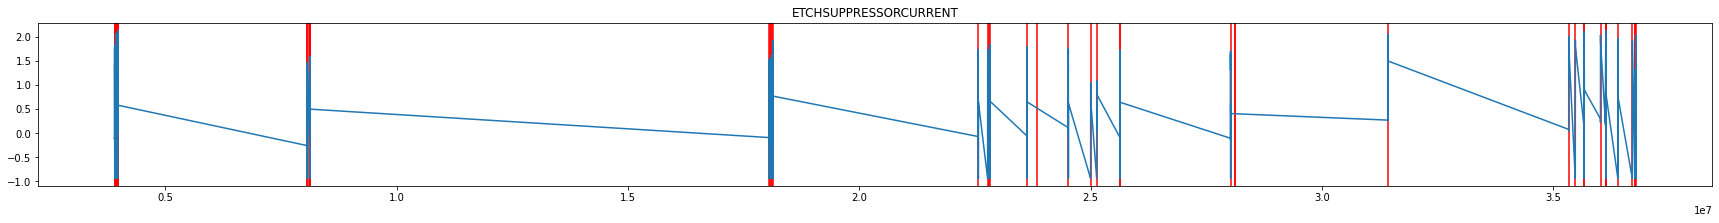

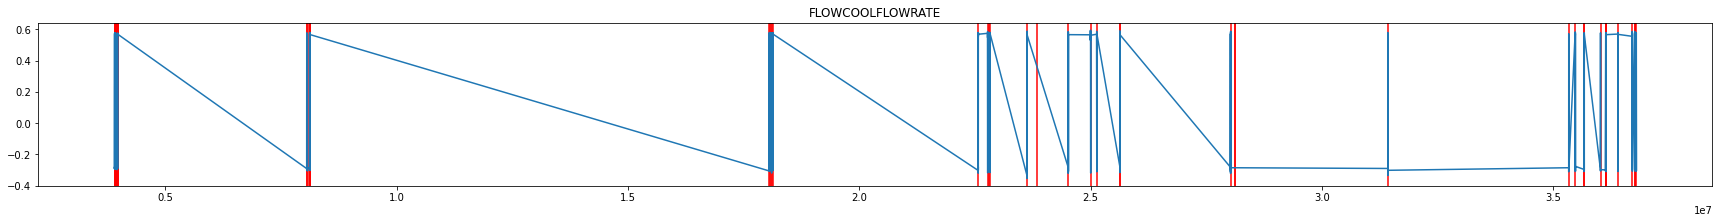

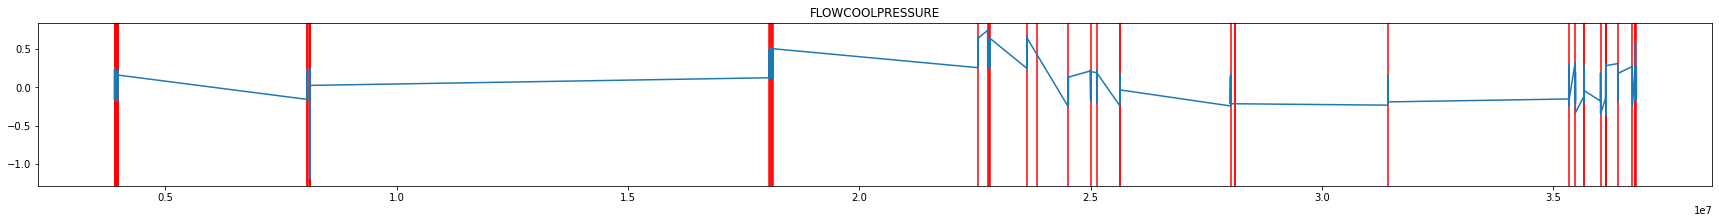

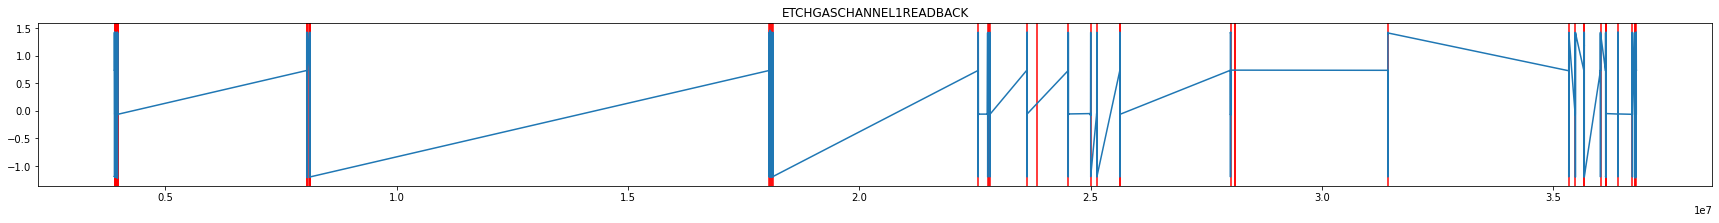

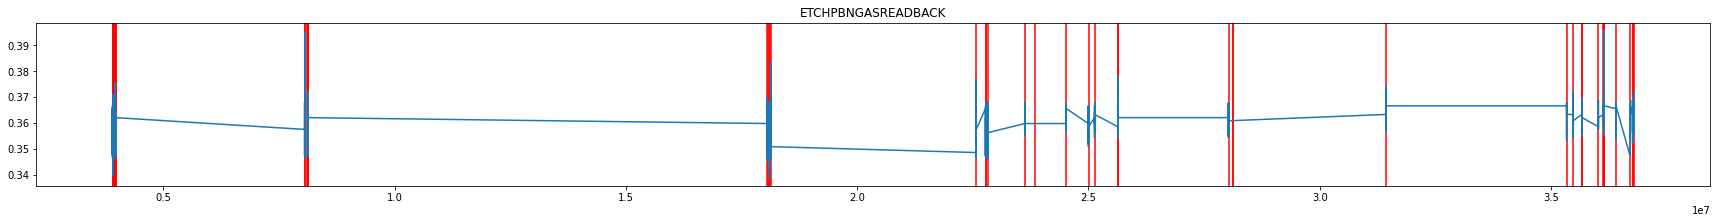

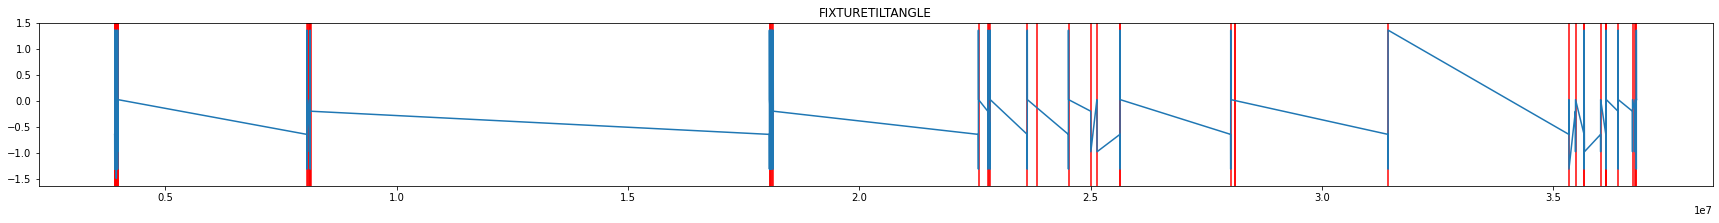

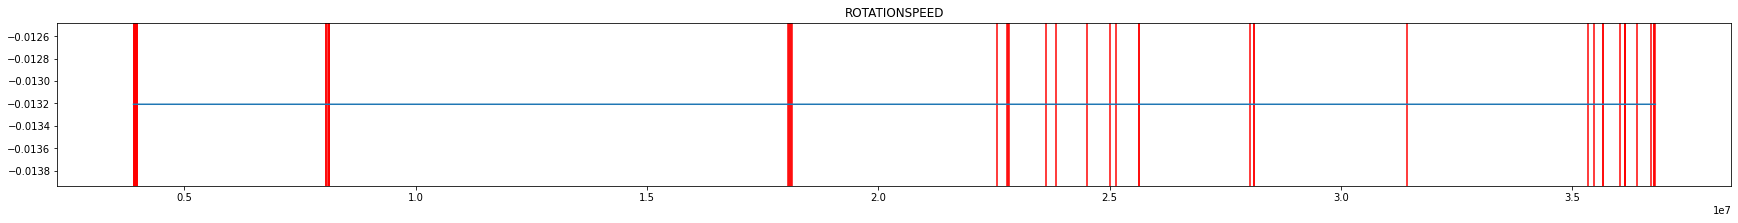

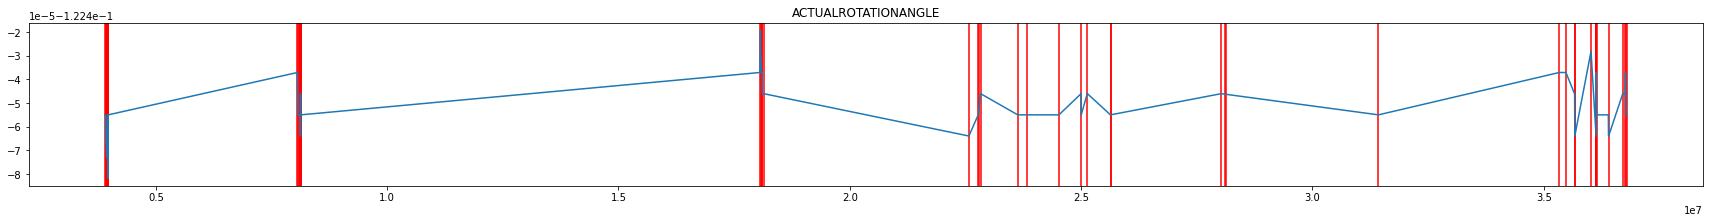

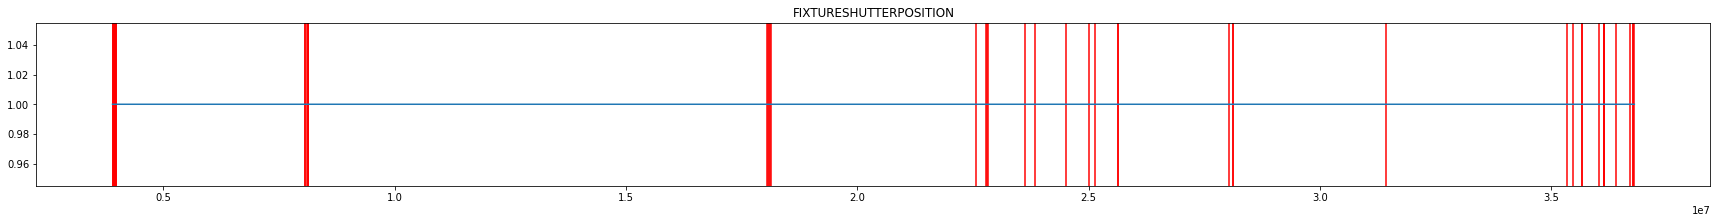

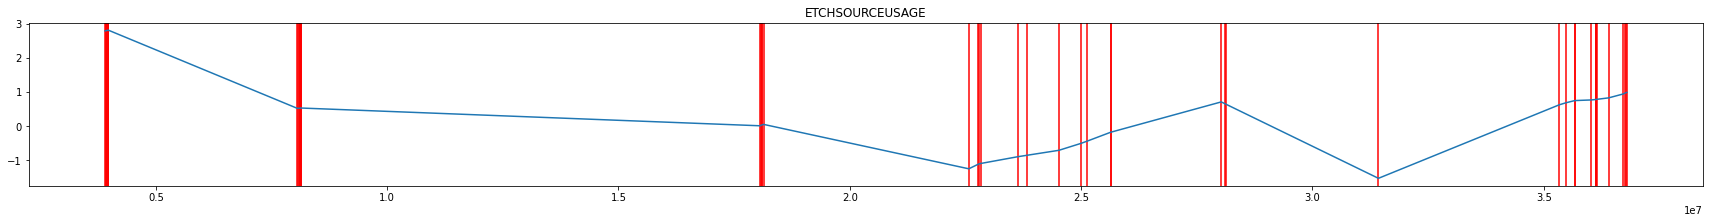

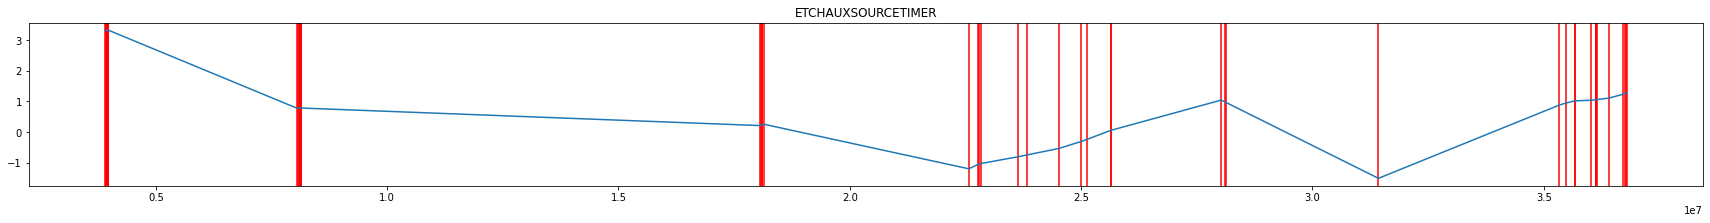

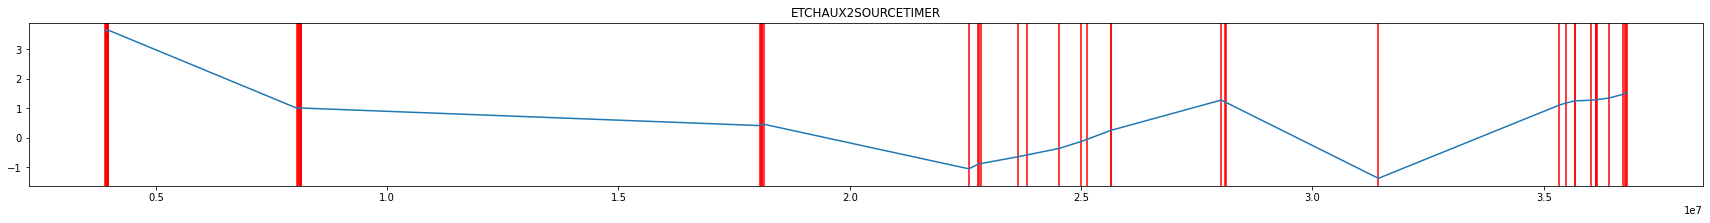

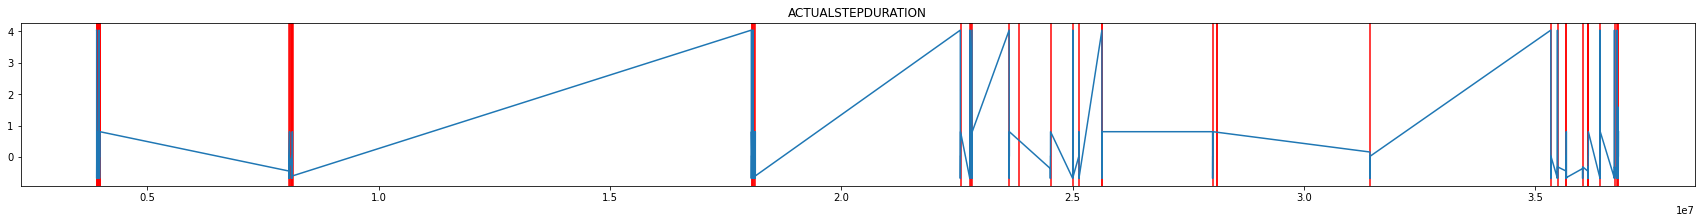

In [19]:
#FlowCool Pressure Dropped Below Limit graph and failures
for column in df_f1.columns[7:24]:
  plt.figure(figsize = (30, 3))
  for i in df_fault.index:
    if df_fault['fault_name'][i] == 'FlowCool Pressure Dropped Below Limit':
      plt.axvline(x = df_fault['time'][i], color = 'red')
  plt.plot(df_f1['time'], df_f1[column])
  plt.title(column)

  plt.show()

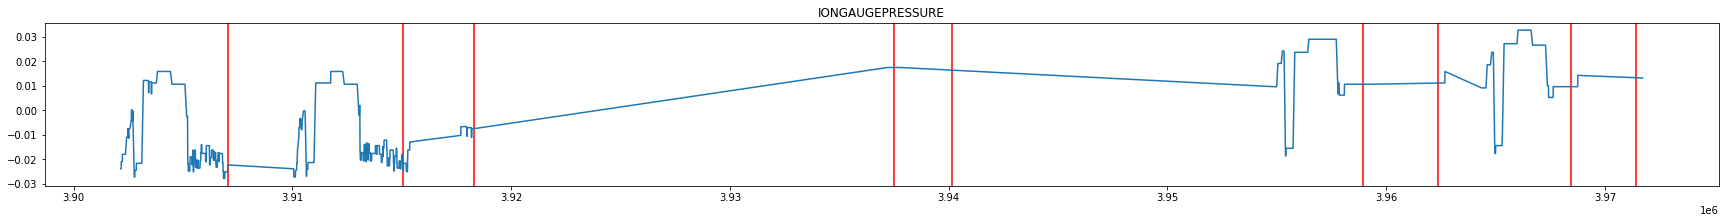

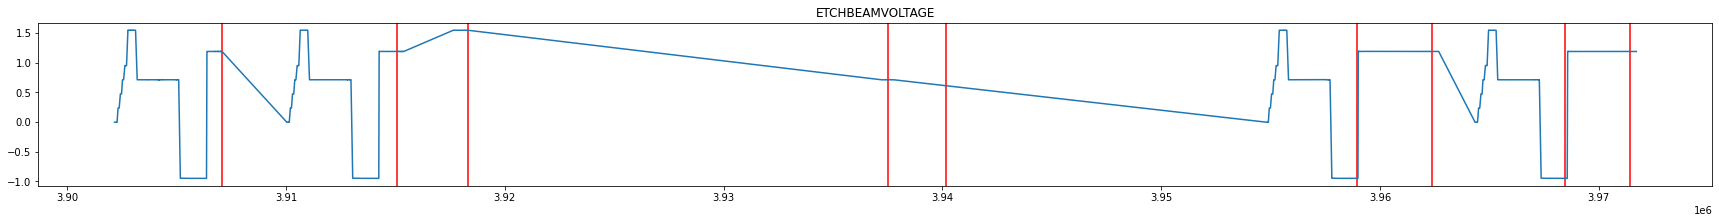

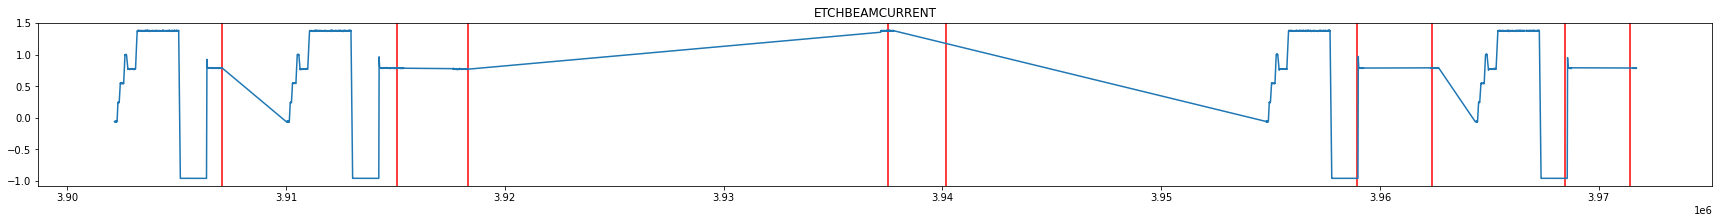

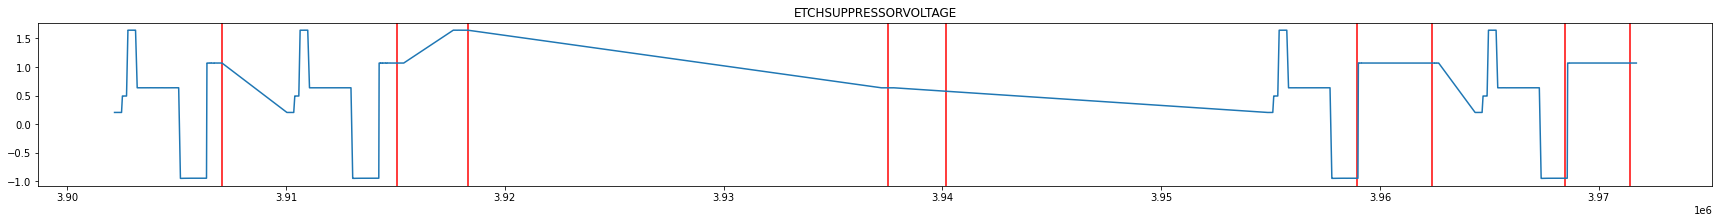

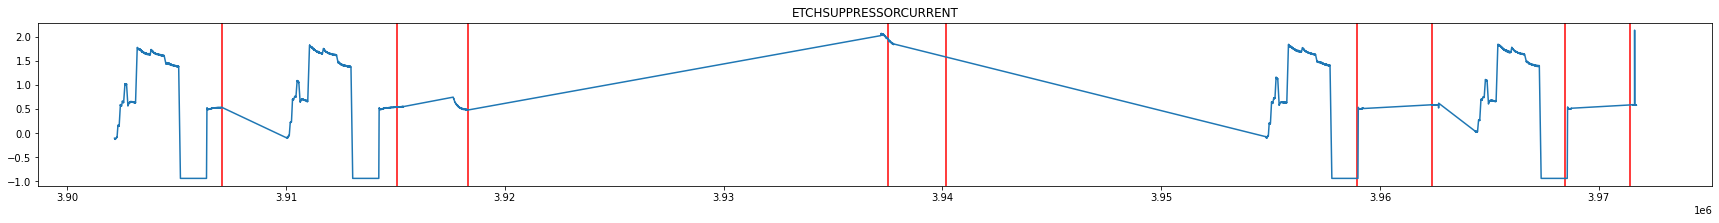

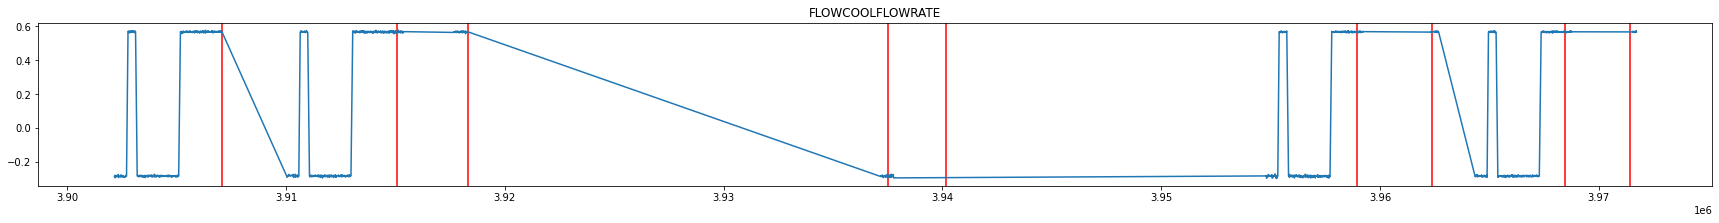

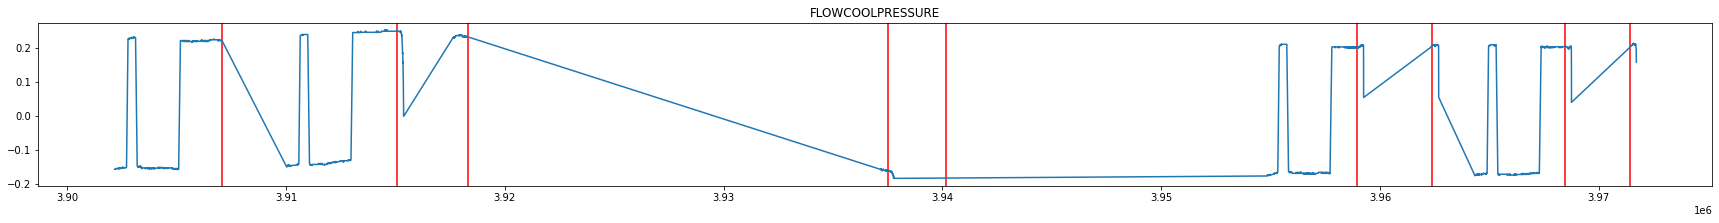

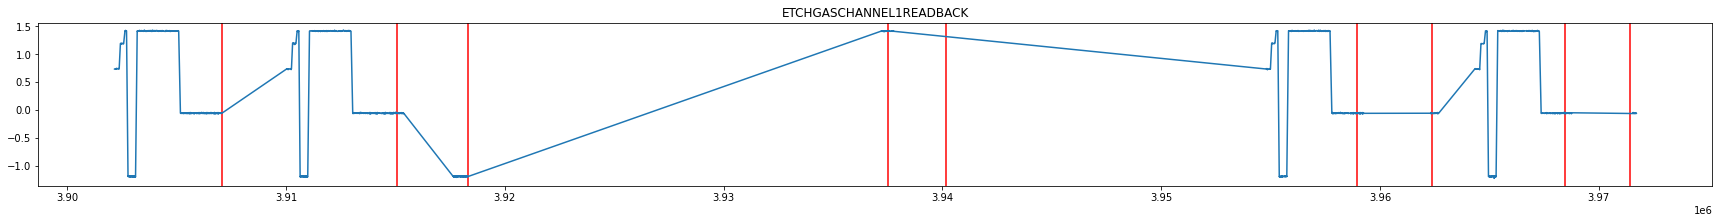

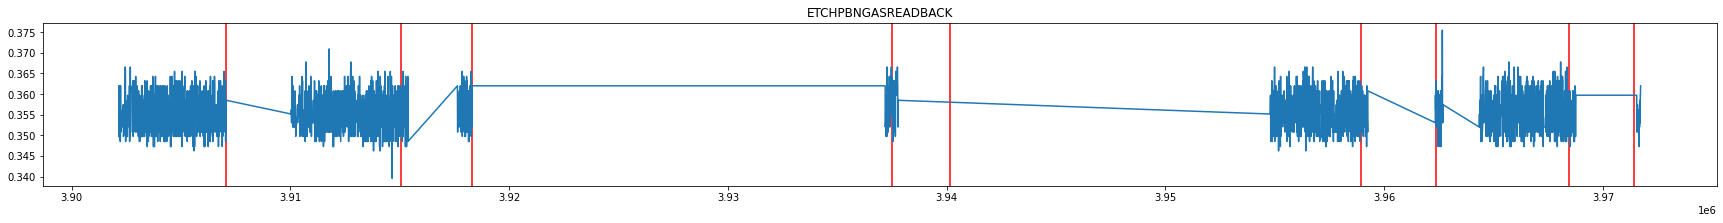

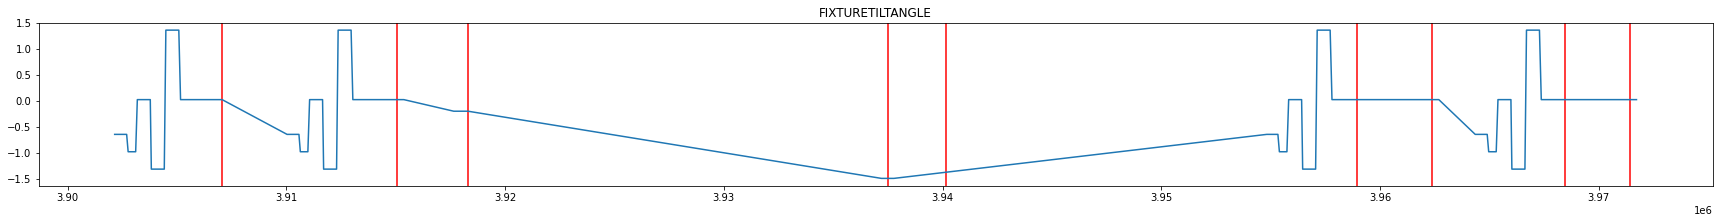

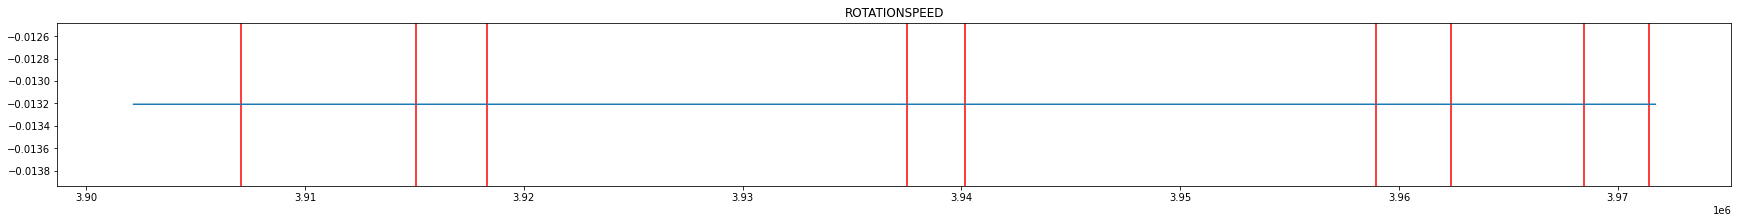

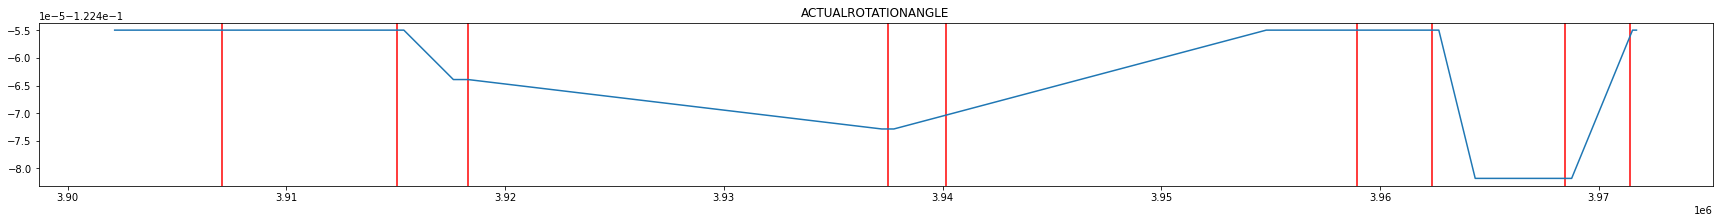

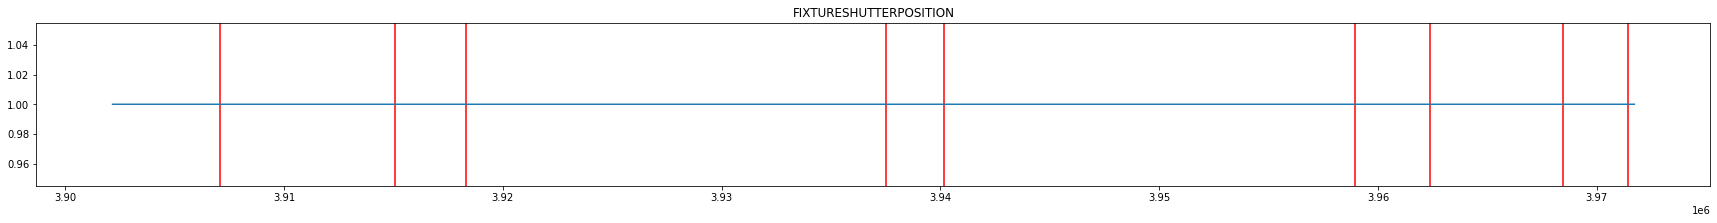

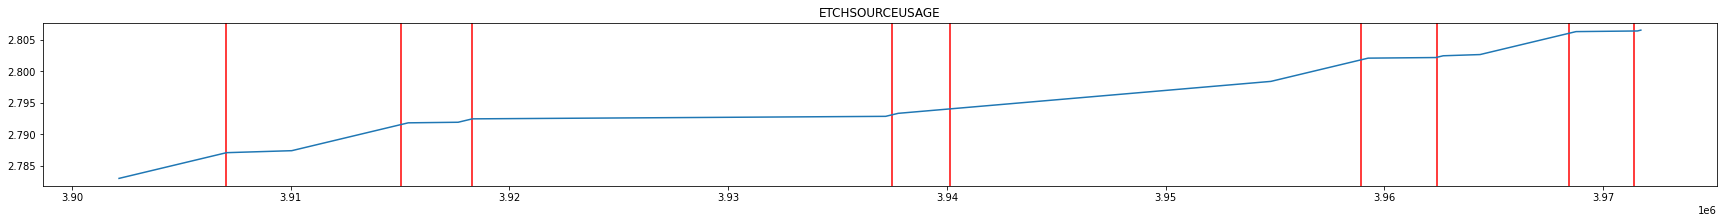

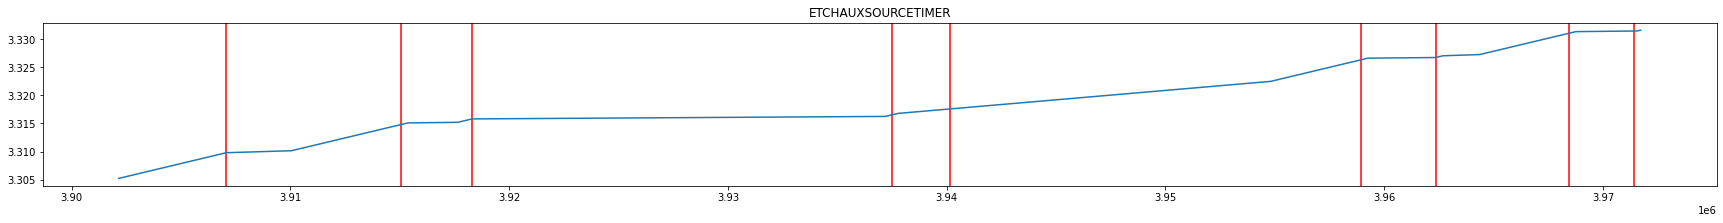

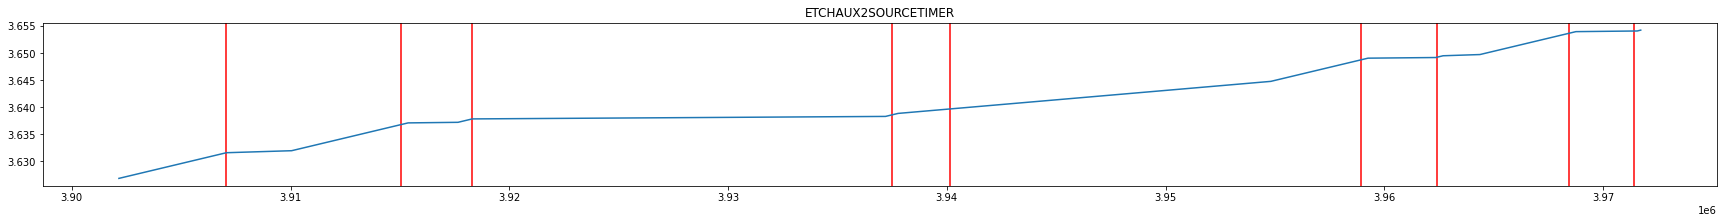

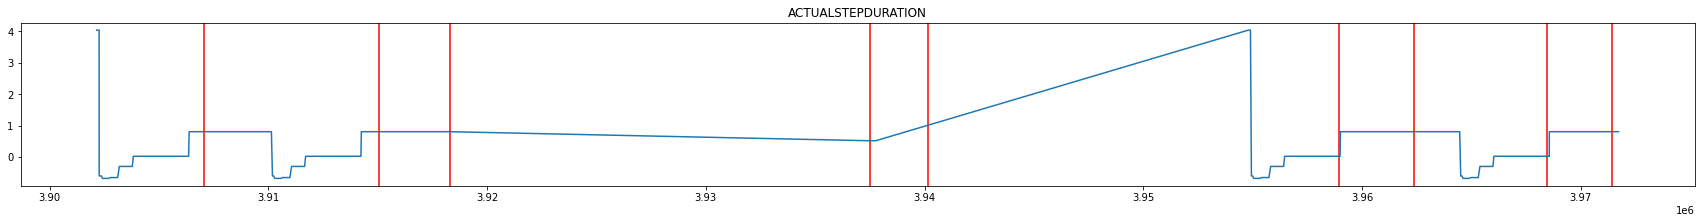

In [28]:
#zooming into first cluster of failures of type f1
df_testf1 = df_f1.loc[df_f1['time'] < 3973348]
df_testfault = df_fault.loc[df_fault['time'] < 3973348]

for column in df_testf1.columns[7:24]:
  plt.figure(figsize = (30, 3))
  for i in df_testfault.index:
    if df_testfault['fault_name'][i] == 'FlowCool Pressure Dropped Below Limit':
      plt.axvline(x = df_testfault['time'][i], color = 'red')
  plt.plot(df_testf1['time'], df_testf1[column])
  plt.title(column)

  plt.show()

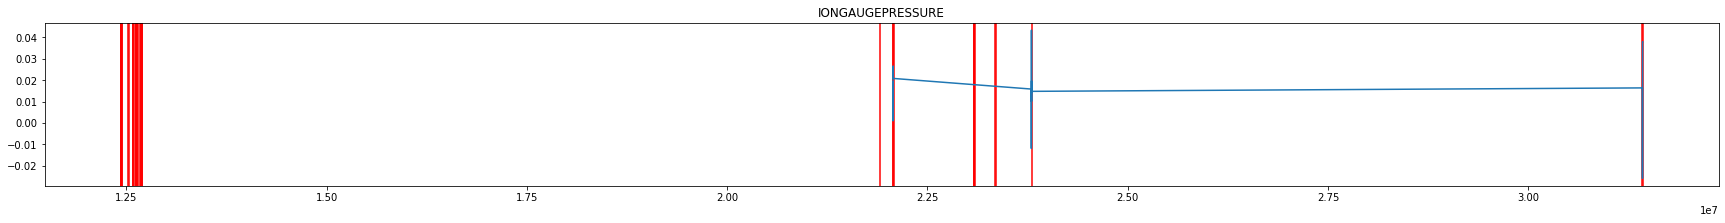

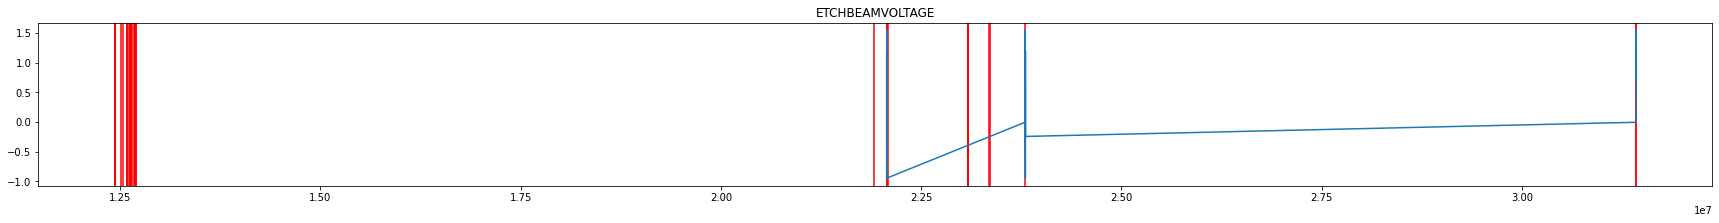

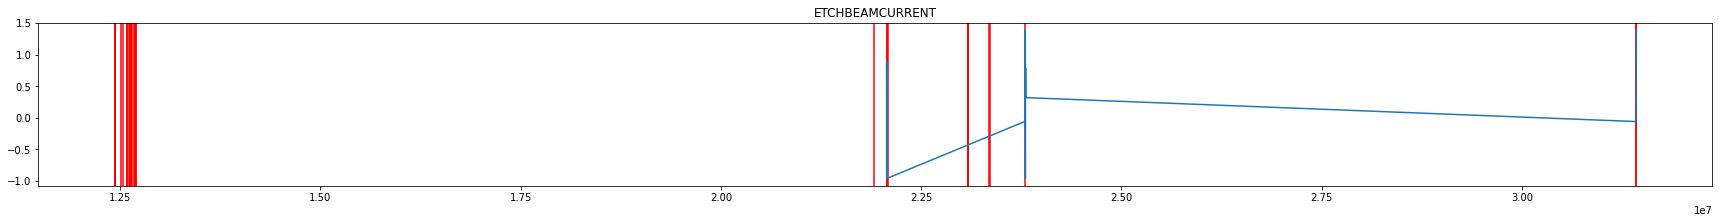

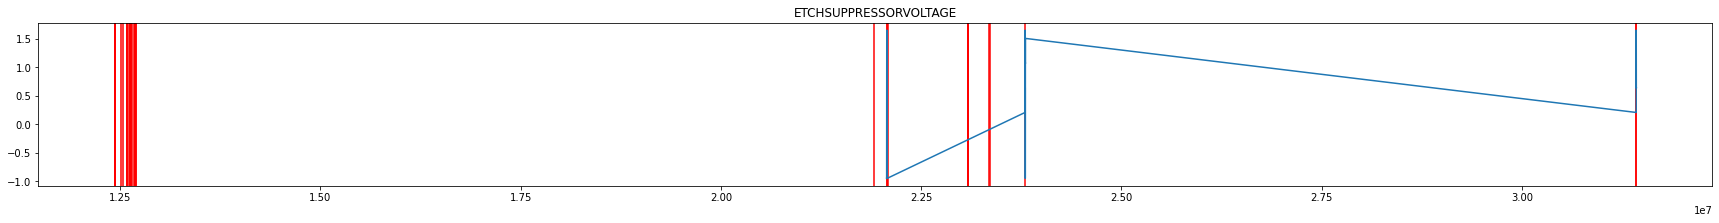

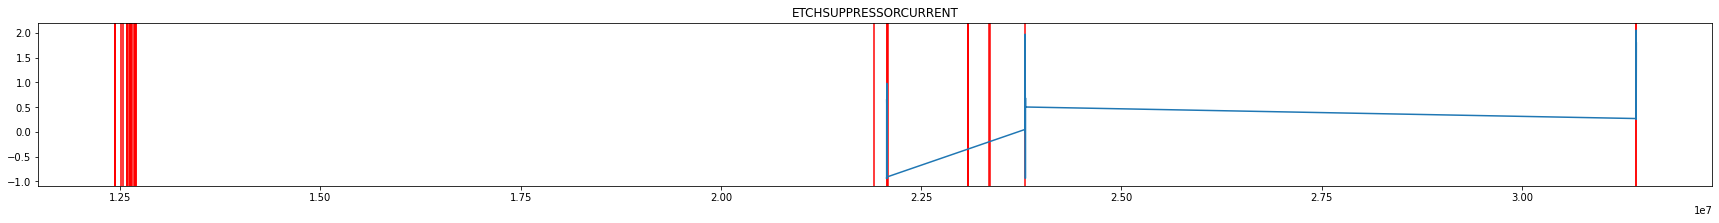

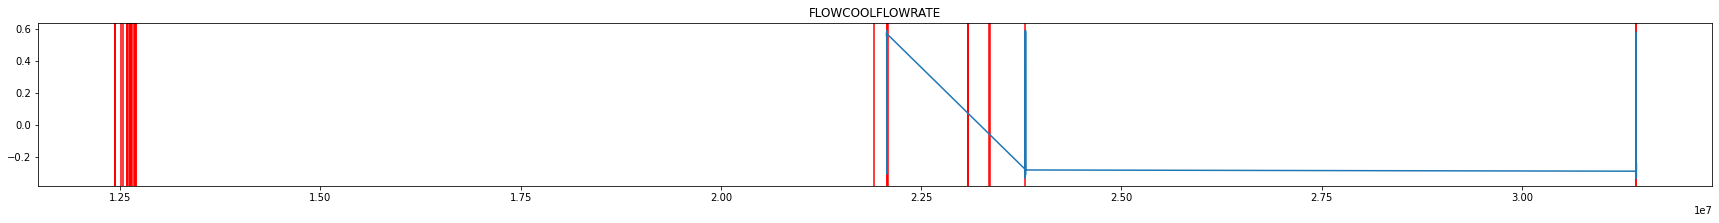

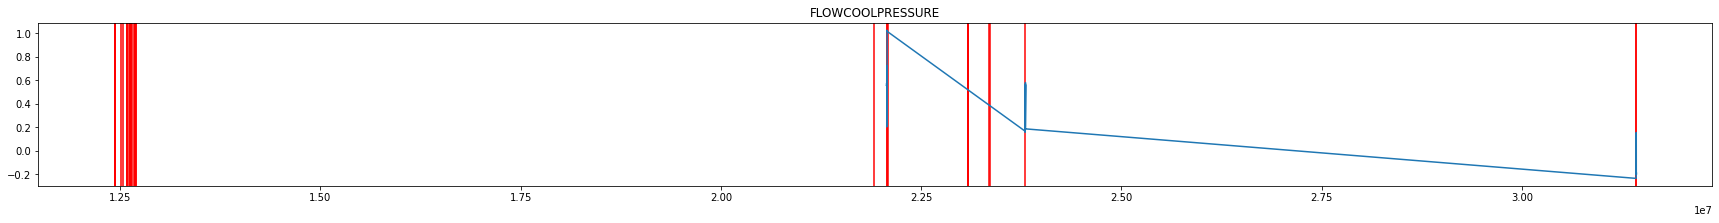

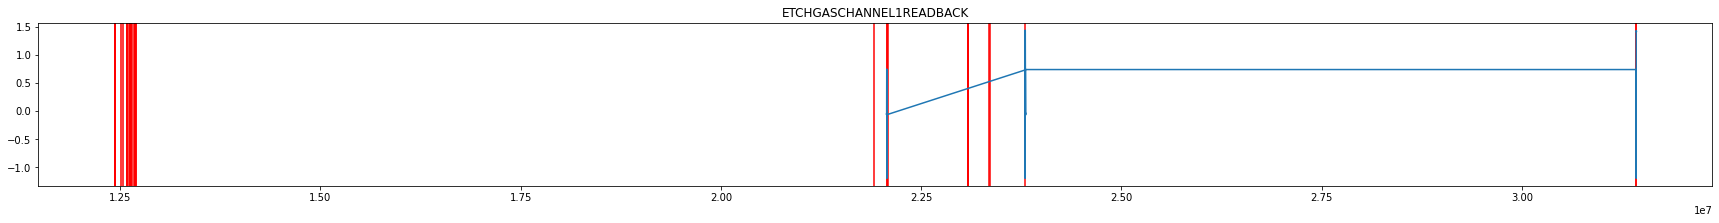

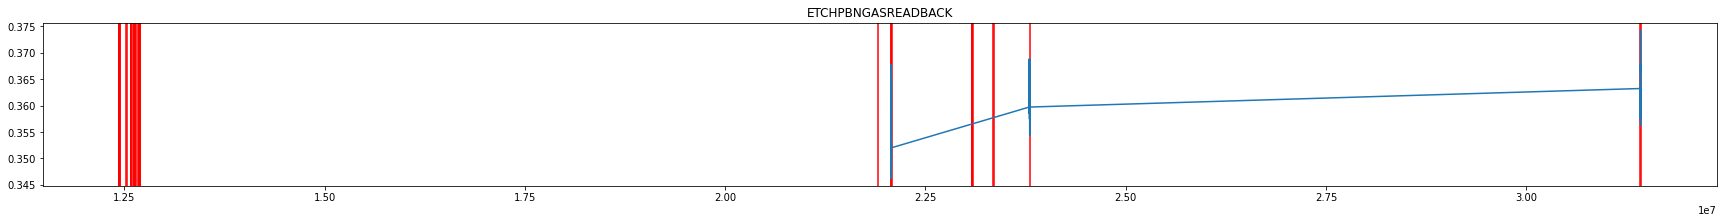

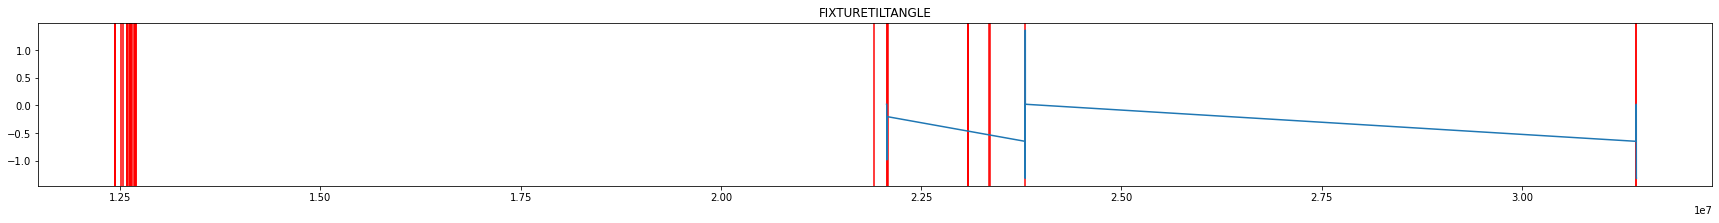

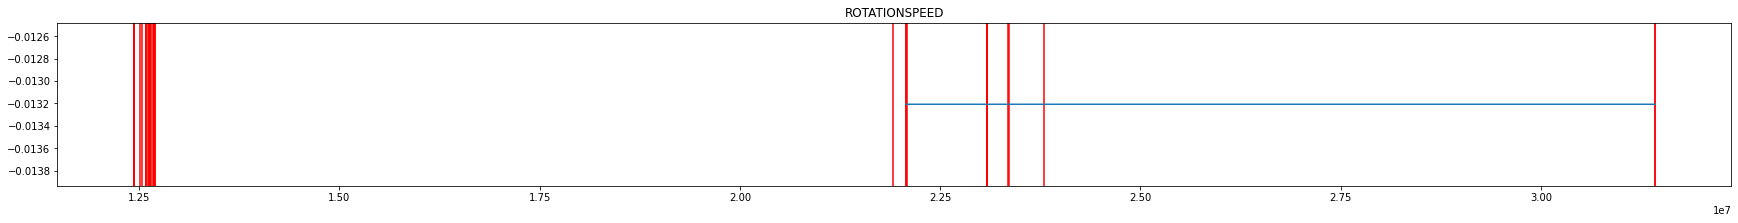

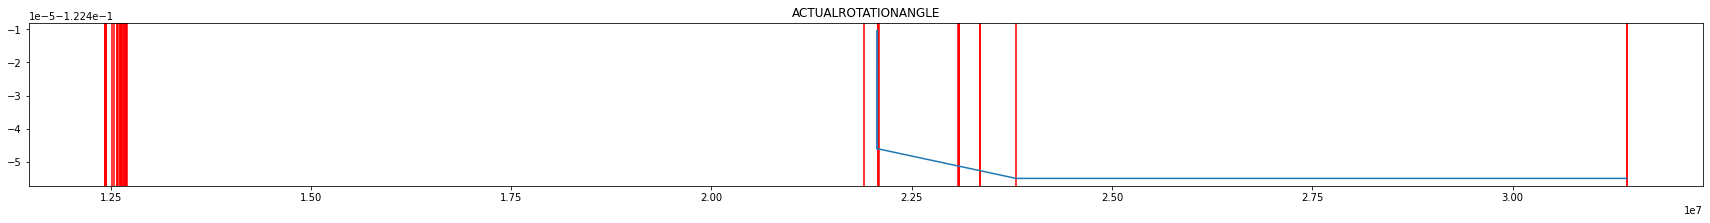

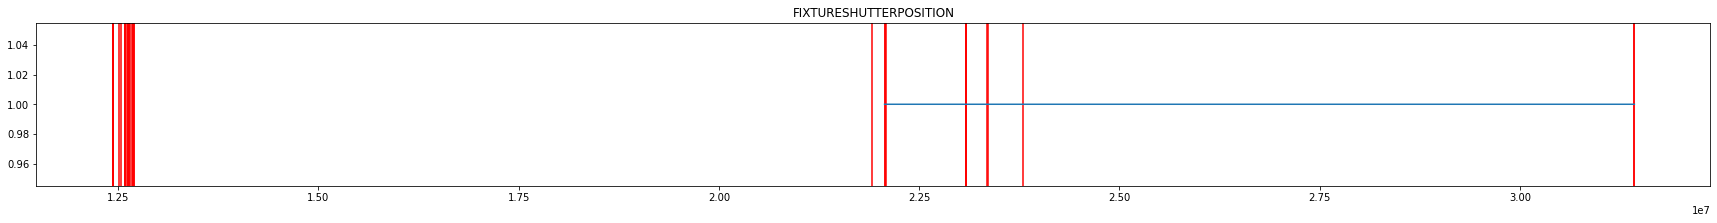

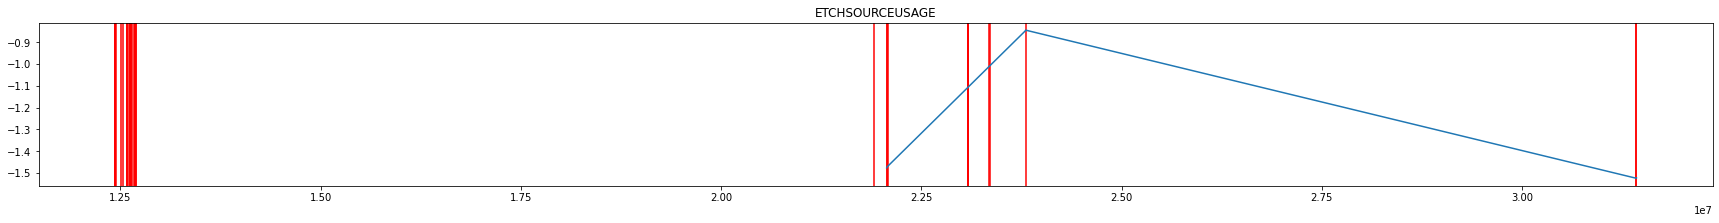

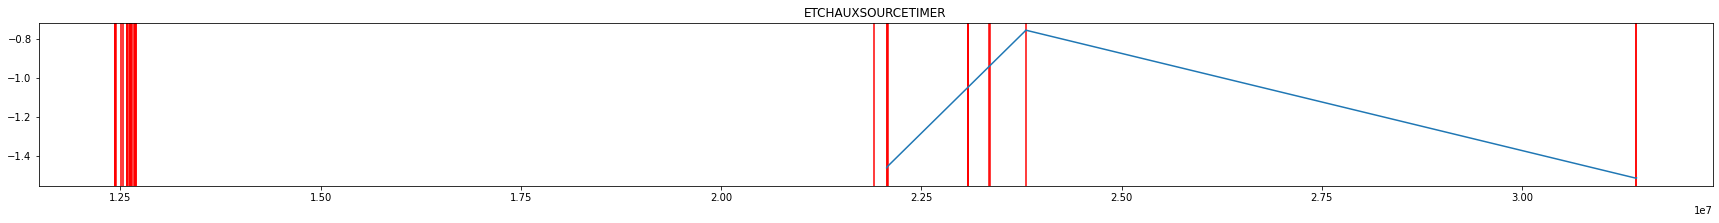

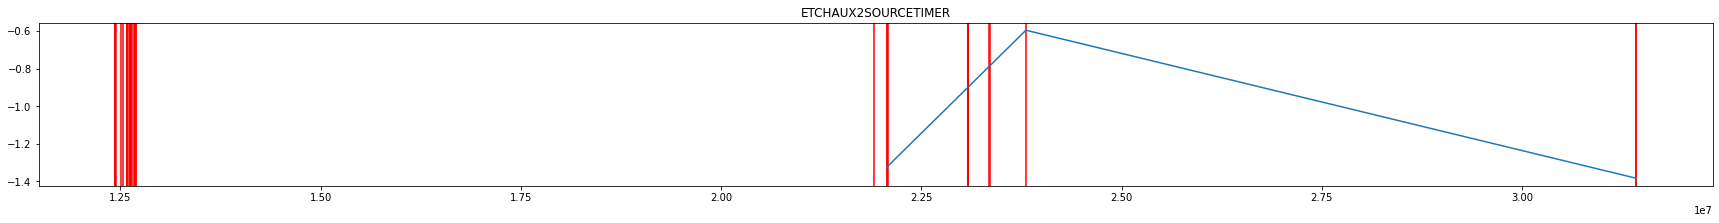

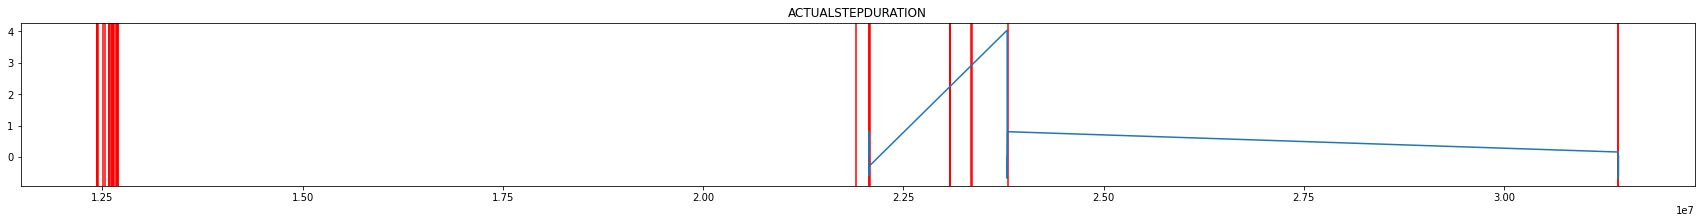

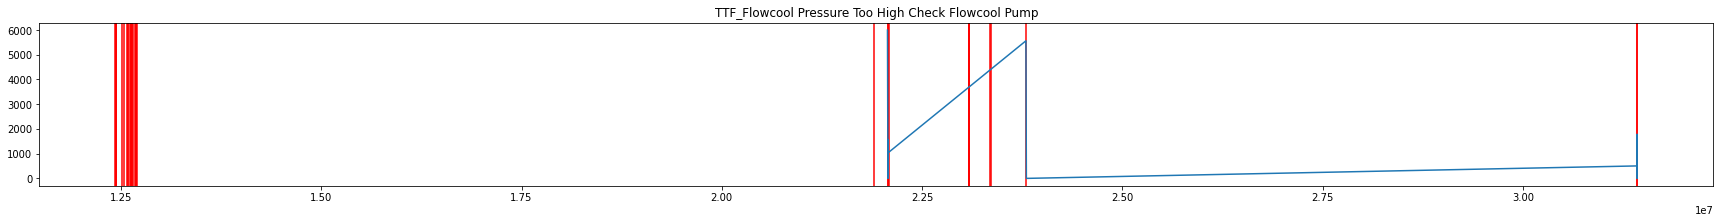

In [20]:
#Flowcool Pressure Too High Check Flowcool Pump graph and failures
for column in df_f2.columns[7:25]:
  plt.figure(figsize = (30, 3))
  for i in df_fault.index:
    if df_fault['fault_name'][i] == 'Flowcool Pressure Too High Check Flowcool Pump':
      plt.axvline(x = df_fault['time'][i], color = 'red')
  plt.plot(df_f2['time'], df_f2[column])
  plt.title(column)

  plt.show()

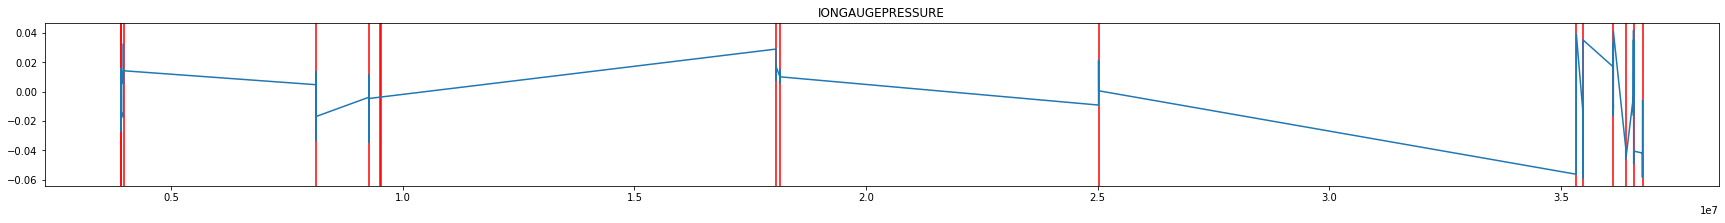

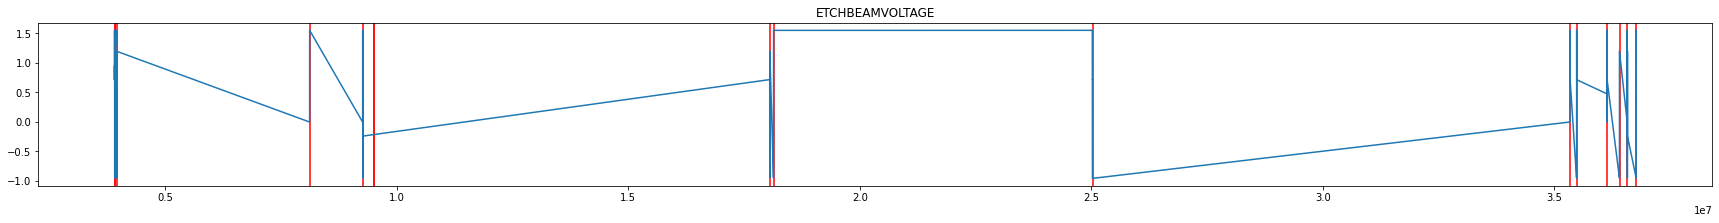

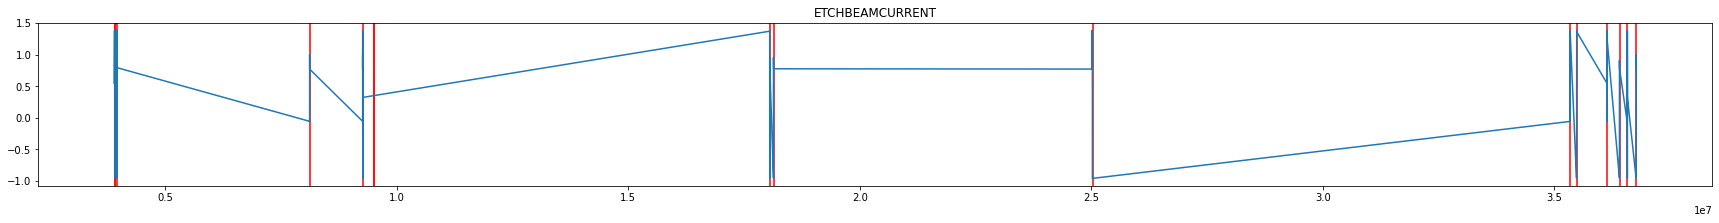

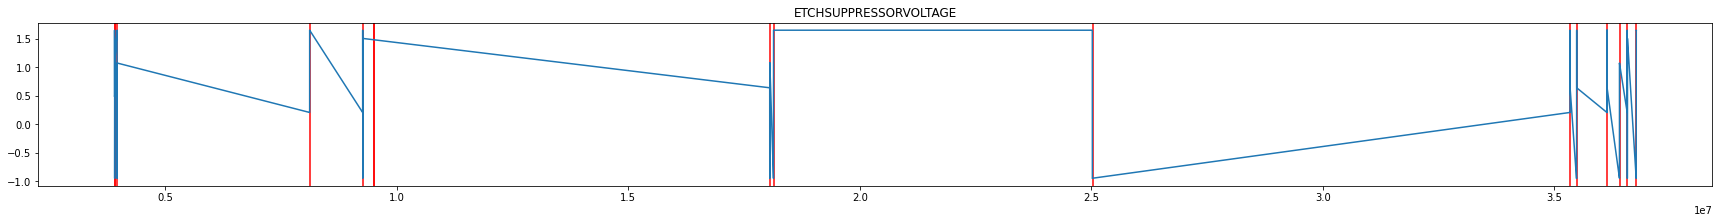

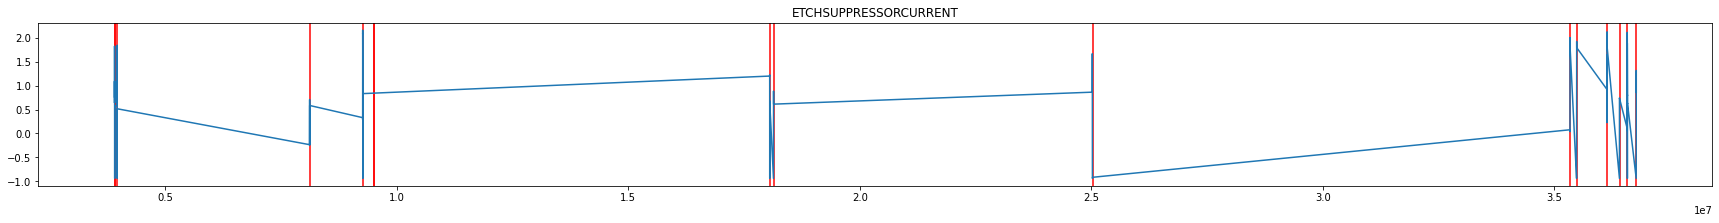

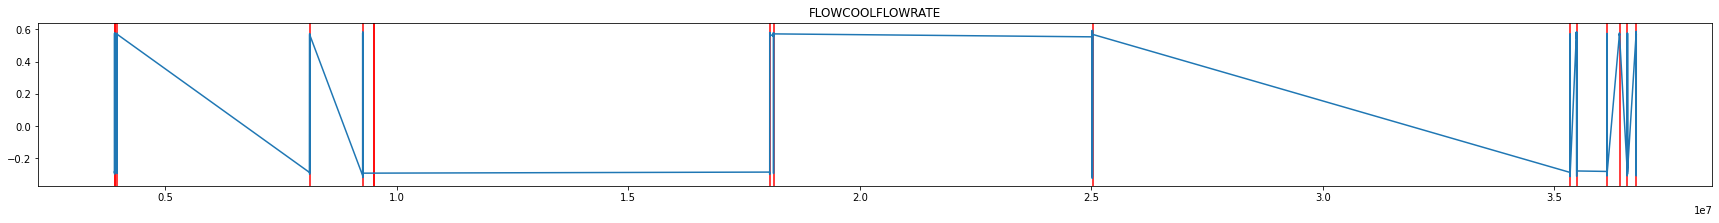

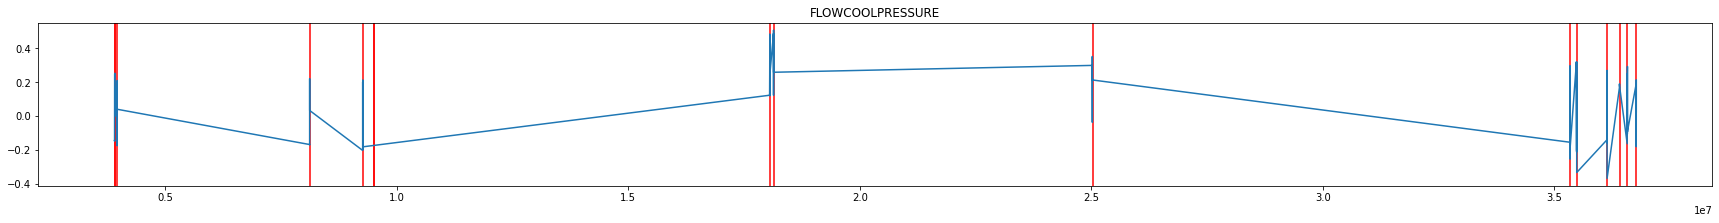

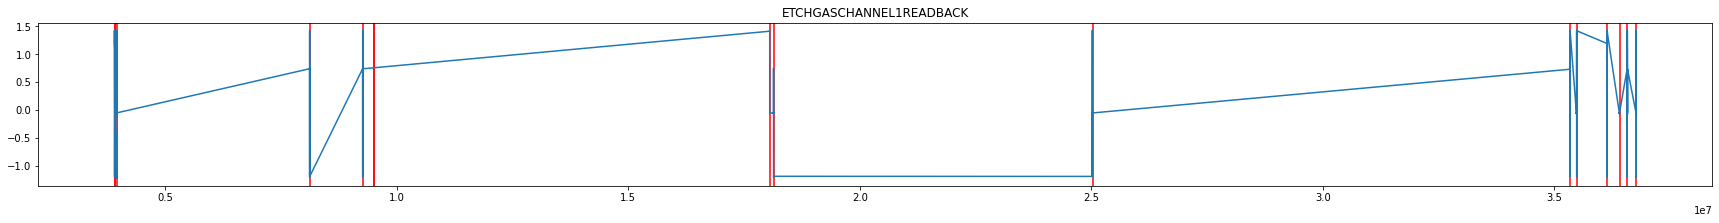

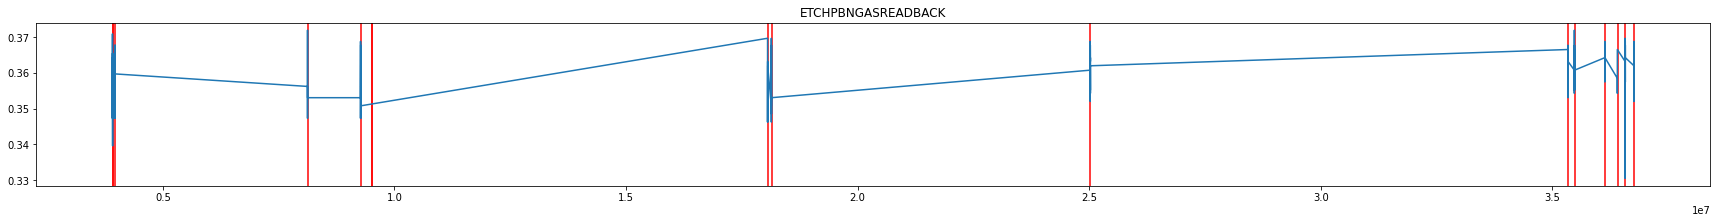

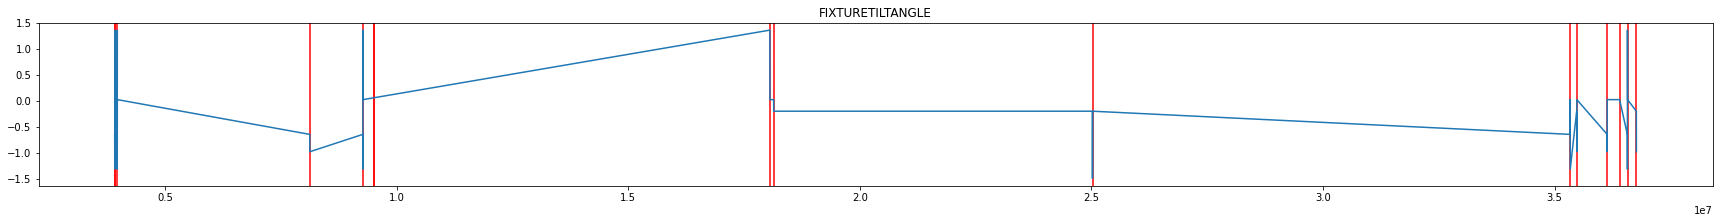

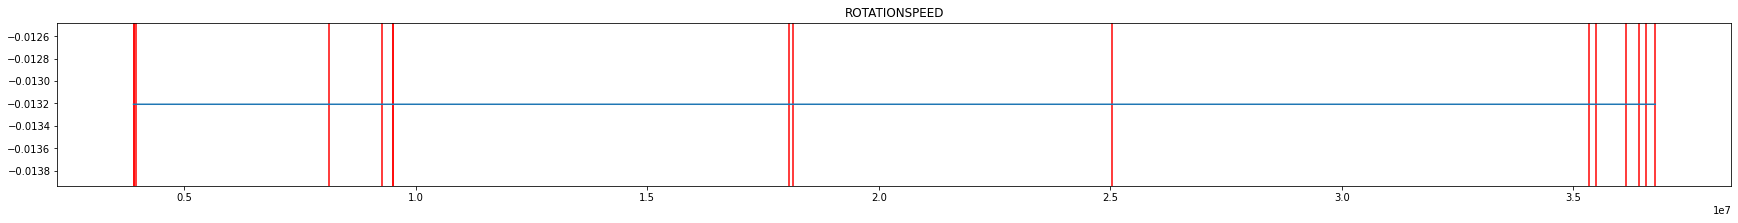

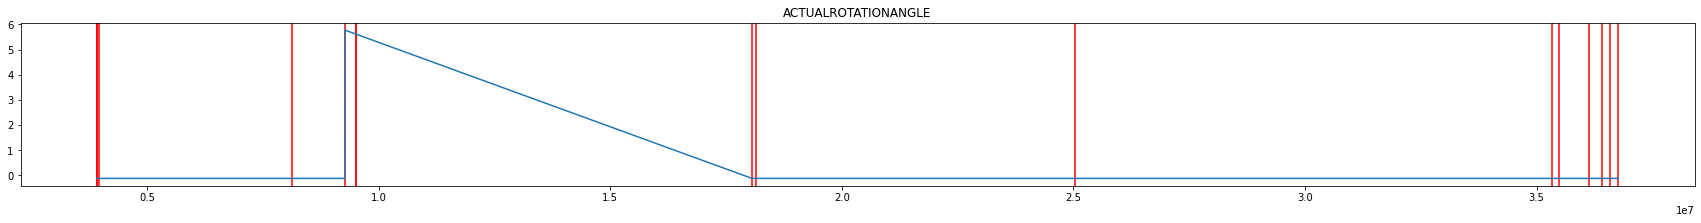

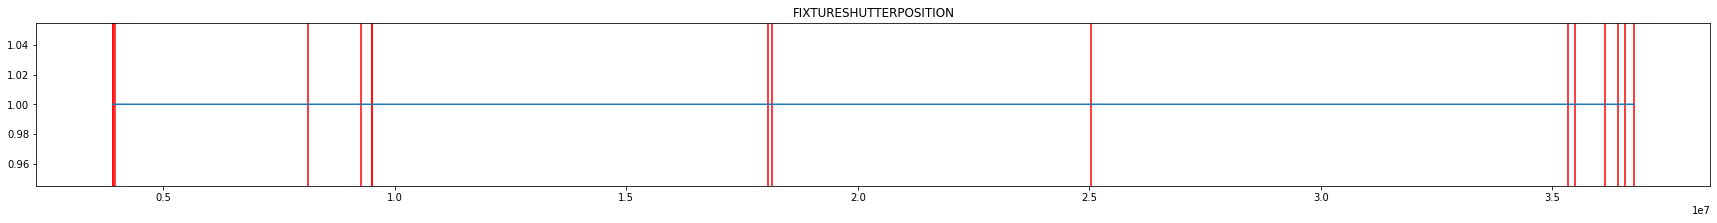

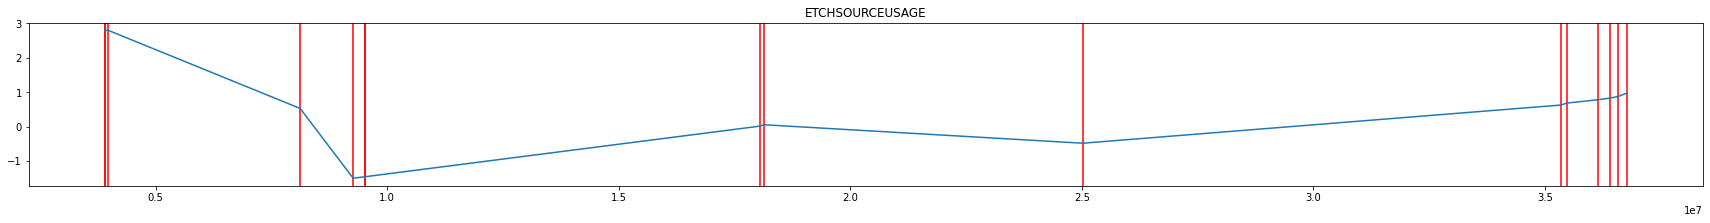

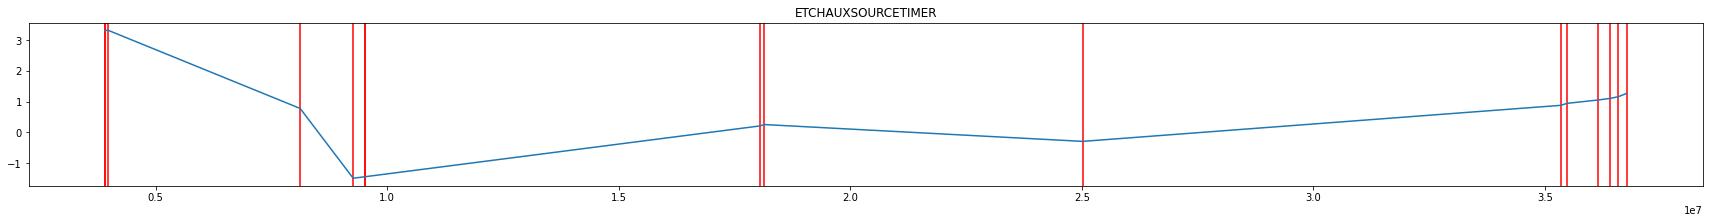

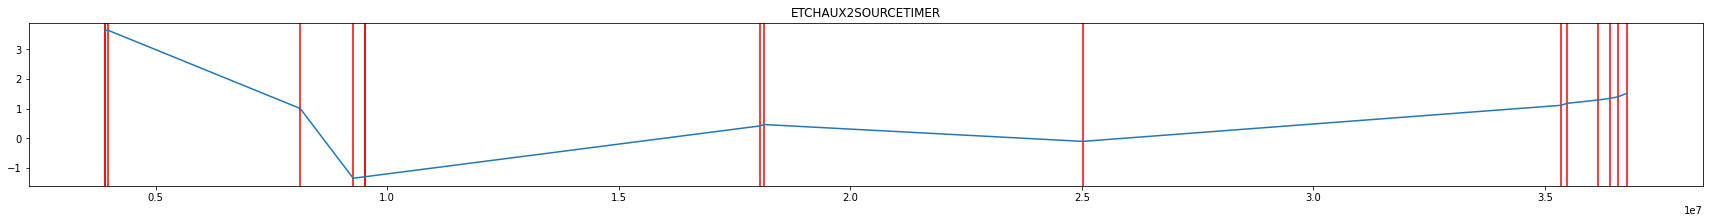

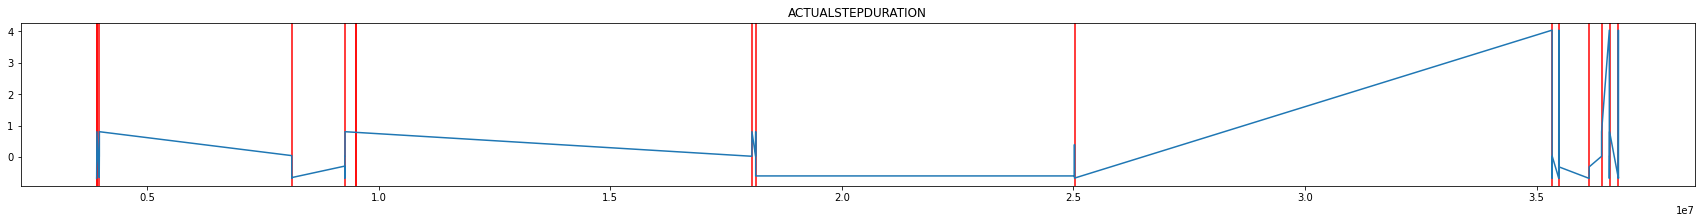

In [22]:
#Flowcool leak graph and failures
for column in df_f3.columns[7:24]:
  plt.figure(figsize = (30, 3))
  for i in df_fault.index:
    if df_fault['fault_name'][i] == 'Flowcool leak':
      plt.axvline(x = df_fault['time'][i], color = 'red')
  plt.plot(df_f3['time'], df_f3[column])
  plt.title(column)

  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


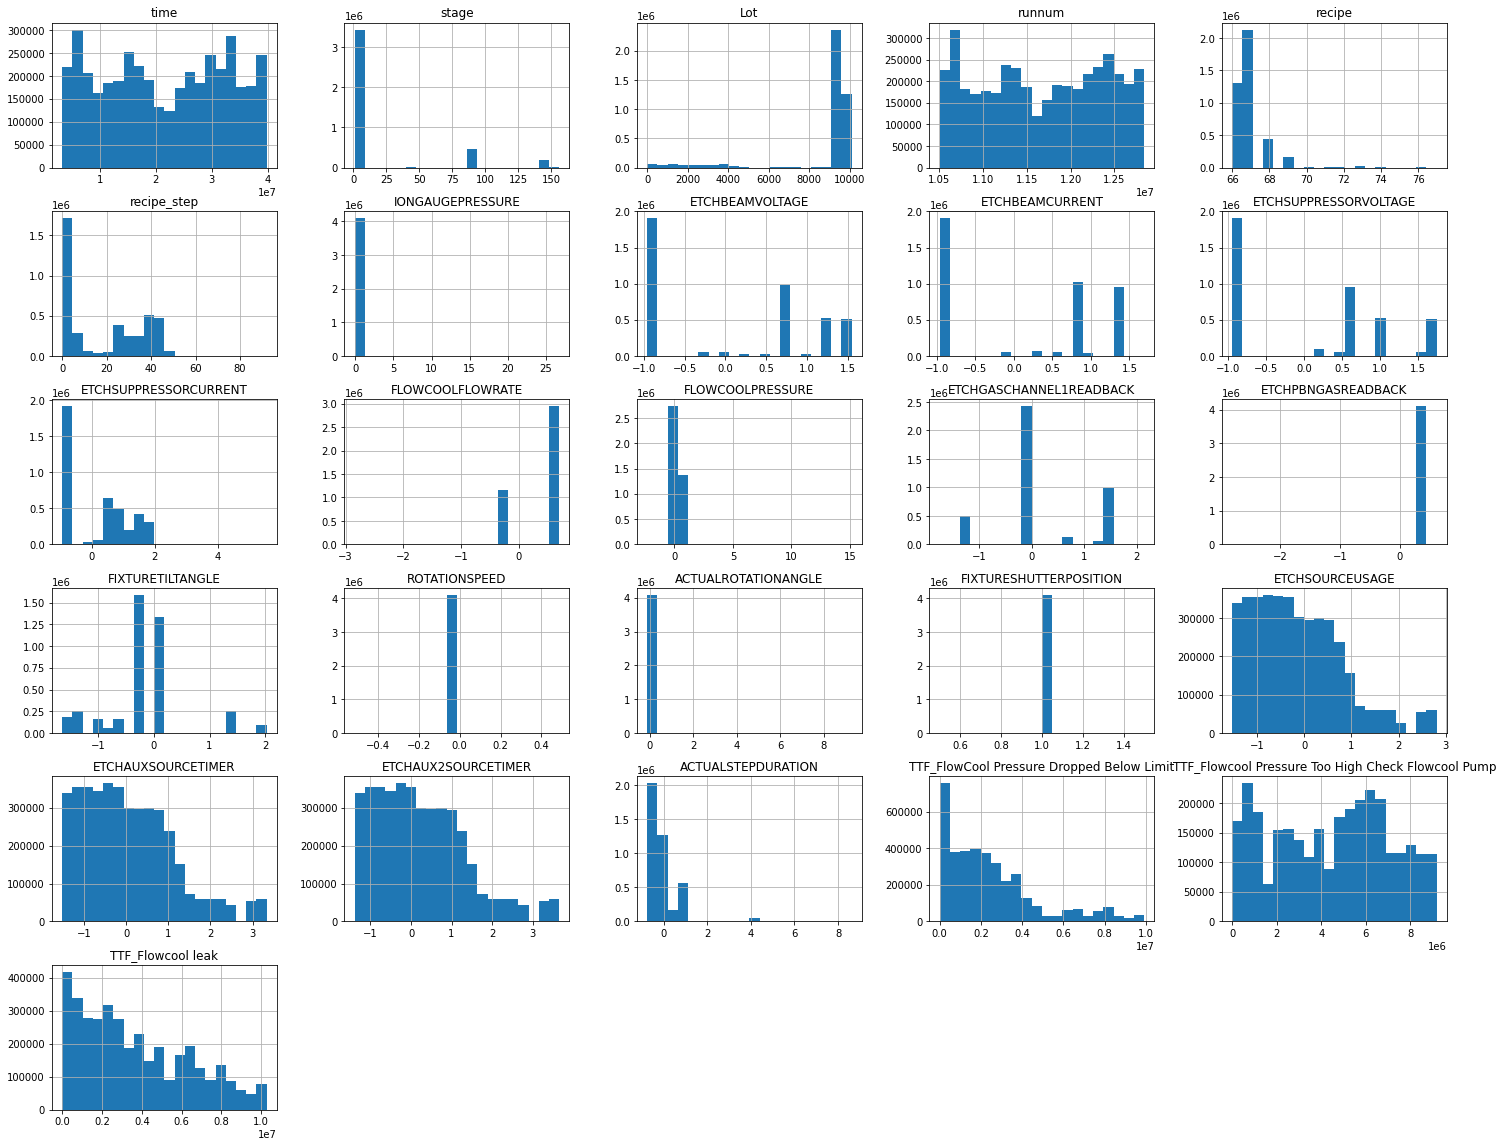

In [23]:
fig = plt.figure(figsize = (25,20))
ax = fig.gca()
hist = df.hist(bins=20, ax = ax)

In [21]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
time,4101355.00000,21499478.18330,10932678.83697,3284030.00000,11891892.00000,21244498.00000,31659888.00000,39789840.00000
stage,4101355.00000,17.69107,39.48889,1.00000,1.00000,1.00000,1.00000,156.00000
Lot,4101355.00000,8593.72305,2361.84864,0.00000,9191.00000,9332.00000,9614.00000,10106.00000
runnum,4101355.00000,11678913.97632,700515.90731,10511673.00000,11059045.00000,11687481.00000,12327503.00000,12838177.00000
recipe,4101355.00000,66.96662,1.09389,66.00000,66.00000,67.00000,67.00000,77.00000
recipe_step,4101355.00000,19.29794,16.60470,0.00000,3.00000,11.00000,38.00000,92.00000
IONGAUGEPRESSURE,4101355.00000,0.00494,0.08806,-0.07961,-0.00034,0.00859,0.01854,26.73743
ETCHBEAMVOLTAGE,4101355.00000,0.07810,1.00850,-0.96014,-0.94937,0.47186,0.95040,1.54968
ETCHBEAMCURRENT,4101355.00000,0.08745,1.01273,-0.96391,-0.95908,0.54237,0.79084,1.69201
ETCHSUPPRESSORVOLTAGE,4101355.00000,0.07590,1.00882,-0.94872,-0.94748,0.49344,1.06910,1.74978


In [ ]:
df_ttf[df_ttf.isnull().any(axis=1)]

#after the last occurance of a failure, that failure will always report null in TTF
#maybe replace nulls with -1 so we can define cutoffs easily?
#    replacement after %4
#DO NOT replace nulls with 0

#only keep the rows where a number has changed from the last row
#only keep when TTF is < 10000
#SMOTE
#classify TTF < 400 as failure, a close to failure classification rather than failure itself
#    just need to figure out the cutoff

#2 step process
#1. RF or multi-class LR to make health index, then graph prob of failure with RUL cutoff at 0.5
#2. Determine RUL after possible failure soon detected

#plot the columns 7 and after with horizontal lines at the failure times
#plot the TTF
#find the results of the github code we found https://github.com/ninja1mmm/2018-phm-data-challenge

,time,TTF_FlowCool Pressure Dropped Below Limit,TTF_Flowcool Pressure Too High Check Flowcool Pump,TTF_Flowcool leak
3761710,31427354,476.0,NaN,3912088.0
3761711,31427358,472.0,NaN,3912084.0
3761712,31427362,468.0,NaN,3912080.0
3761713,31427366,464.0,NaN,3912076.0
3761714,31427370,460.0,NaN,3912072.0
...,...,...,...,...
5110537,39789824,NaN,NaN,NaN
5110538,39789828,NaN,NaN,NaN
5110539,39789832,NaN,NaN,NaN
5110540,39789836,NaN,NaN,NaN


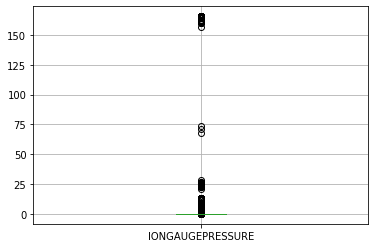

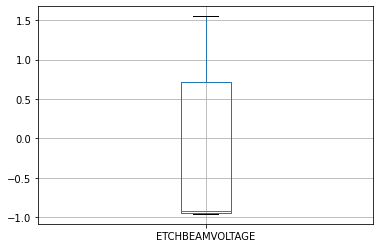

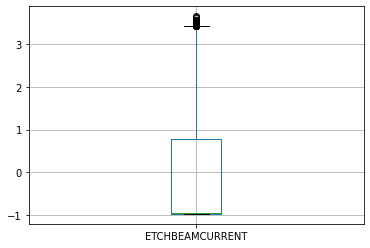

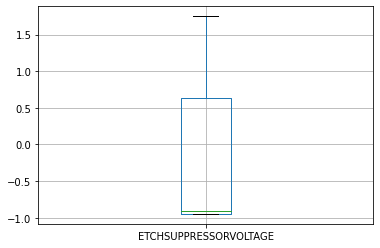

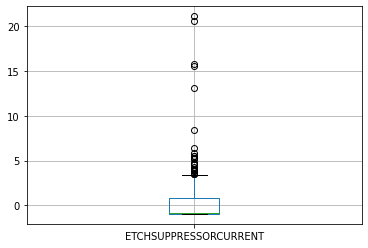

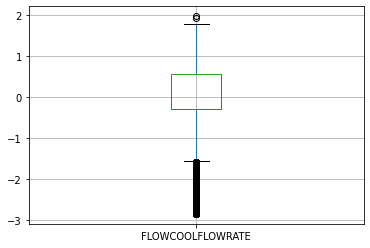

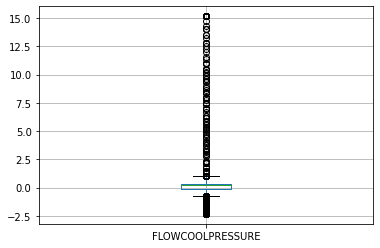

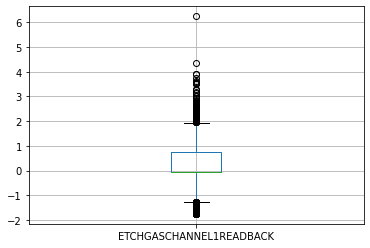

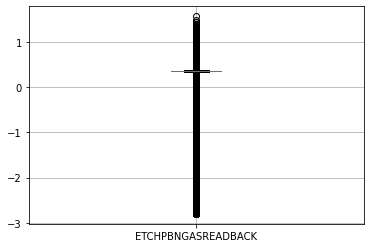

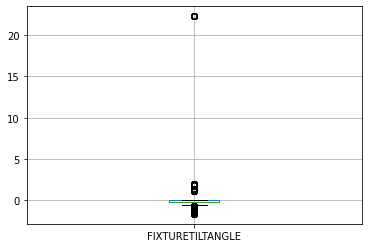

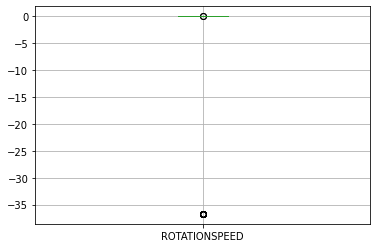

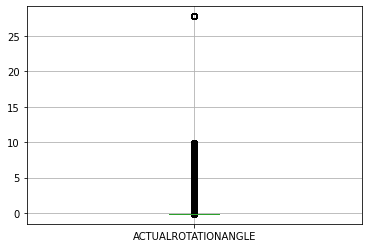

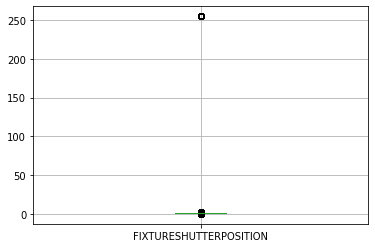

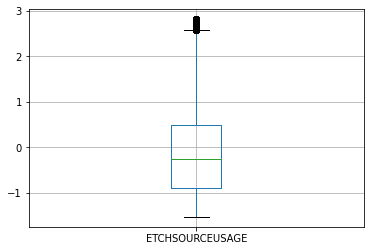

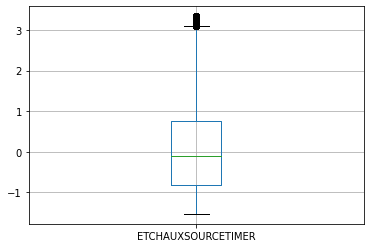

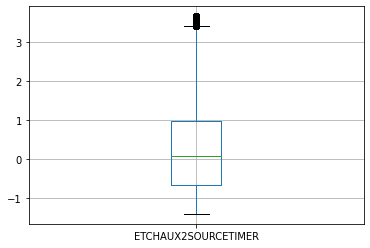

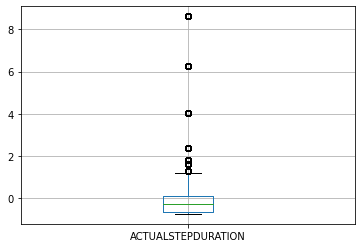

In [24]:
for column in df_train.columns[7:]:
    plt.figure()
    df_train.boxplot([column])